<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TimeSeries Energy

# Install

In [ ]:
!pip install darts

# Setup

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import torch
from pytorch_lightning.callbacks import Callback, EarlyStopping

from darts.datasets import ElectricityDataset
from darts.models.forecasting.linear_regression_model import LinearRegressionModel
from darts.models.forecasting.tcn_model import TCNModel
from darts.models.forecasting.tft_model import TFTModel
from darts.models.forecasting.prophet_model import Prophet

from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MaxAbsScaler

from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.metrics import smape

# Data

In [2]:
ds_all = ElectricityDataset(multivariate=False).load()

100%|██████████| 370/370 [03:18<00:00,  1.87it/s]


## Parameters

In [131]:
DAYS = 60
DURATION = 24 * 4
VAL_DAYS = 14

## Filter

In [132]:
ds = [d[-(DAYS * DURATION) :].astype(np.float32) for d in ds_all]

## Split

In [133]:
# Split in train / val / test
val_len = VAL_DAYS * DURATION

train = [s[: -(2 * val_len)] for s in ds]
val = [s[-(2 * val_len) : -val_len] for s in ds]
test = [s[-val_len:] for s in ds]

# Scale so that the largest value is 1.
# This way of scaling perserves the sMAPE
scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

print(len(train[0]), len(val[0]), len(test[0]))

3072 1344 1344


## EDA

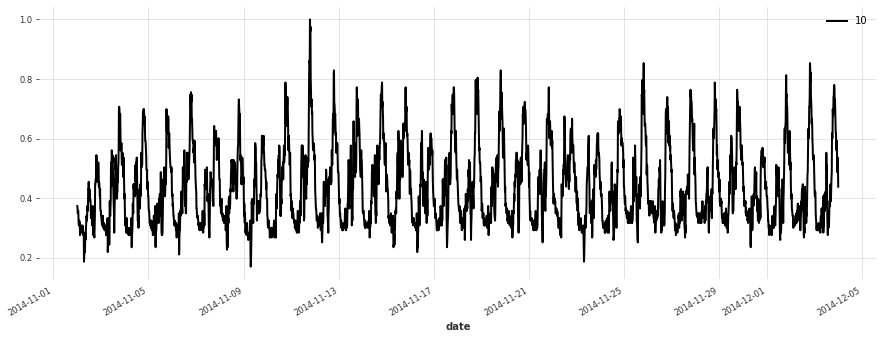

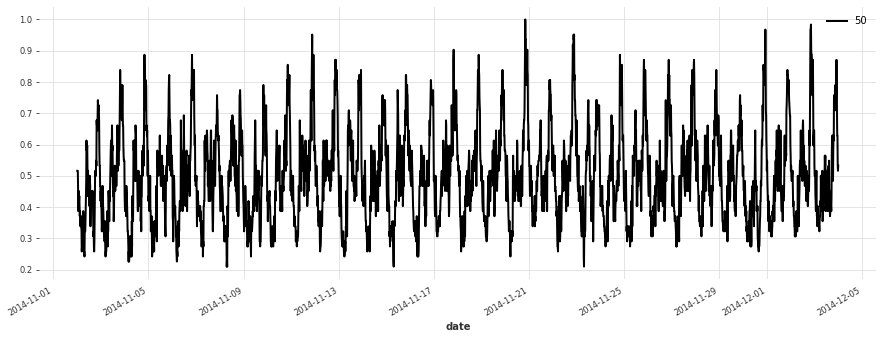

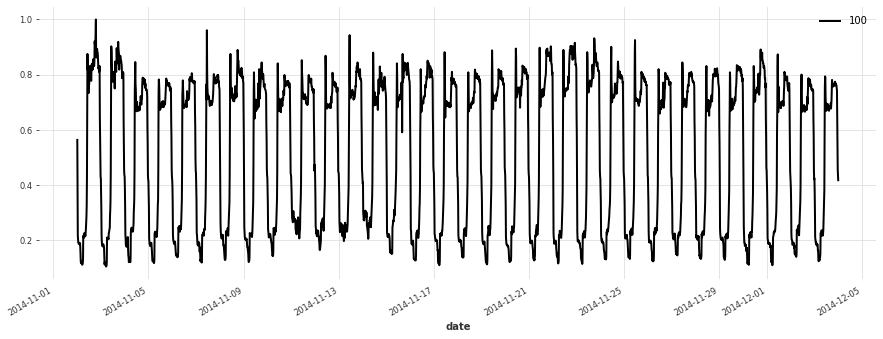

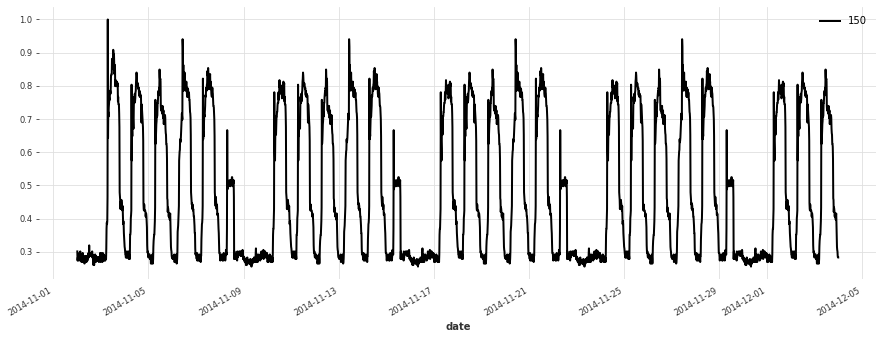

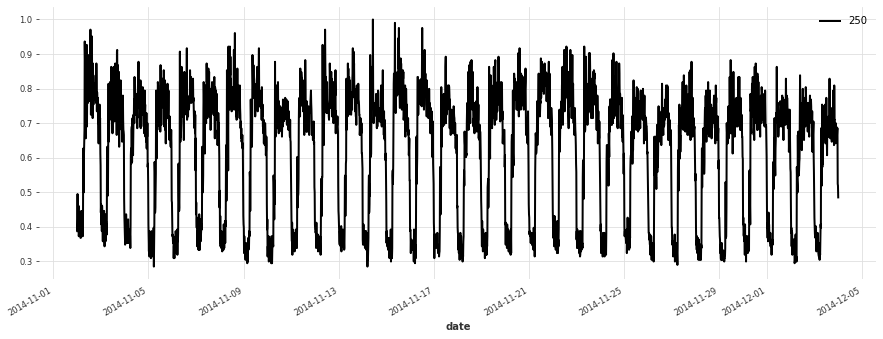

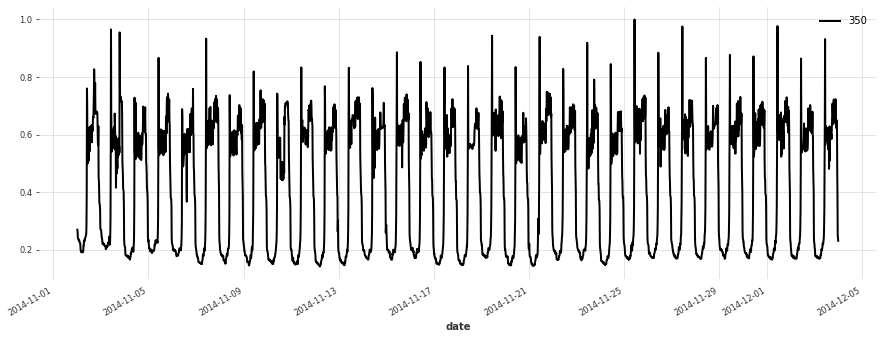

In [134]:
for i in [10, 50, 100, 150, 250, 350]:
    plt.figure(figsize=(15, 5))
    train[i].plot(label="{}".format(i, lw=1))

# Evaluate

In [135]:
def eval_model(preds, name, train_set=train, val_set=val):
  mapes = smape(preds, val_set)
  smape_mean = np.mean(mapes)
  smape_std  = np.std(mapes)
  print(f'{name} sMAPE: {smape_mean:.2f} +- {smape_std:.2f}')

  plt.hist(mapes)
  for i in [10, 50, 100, 150, 250, 350]:
    plt.figure(figsize=(15, 5))
    train_set[i][-7 * DURATION :].plot()
    val_set[i].plot(label="actual")
    preds[i].plot(label="forecast")

  return smape_mean, smape_std

def best_predictions(preds, train_set=train, val_set=val, top=5):
  mapes = smape(preds, val_set)
  sorted = np.argsort(mapes)

  for index in sorted[0 : top]:
    plt.figure(figsize=(15, 5))
    train_set[index][-3 * DURATION :].plot()
    val_set[index].plot(label="actual")
    preds[index].plot(label="forecast")
    plt.title(f'TimeSeries {index} - sMAPE {mapes[index]:.2f}')

def worst_predictions(preds, train_set=train, val_set=val, top=5):
  mapes = smape(preds, val_set)
  sorted = np.argsort(mapes)

  for index in sorted[-top : ]:
    plt.figure(figsize=(15, 5))
    train_set[index][-3 * DURATION :].plot()
    val_set[index].plot(label="actual")
    preds[index].plot(label="forecast")
    plt.title(f'TimeSeries {index} - sMAPE {mapes[index]:.2f}')

In [122]:
results_df = pd.DataFrame(columns=['sMAPE Mean', 'sMAPE STD'])

# Linear Model

In [26]:
lr_model = LinearRegressionModel(lags=7 * DURATION)
lr_model.fit(train);

linear regression sMAPE: 15.72 +- 20.51


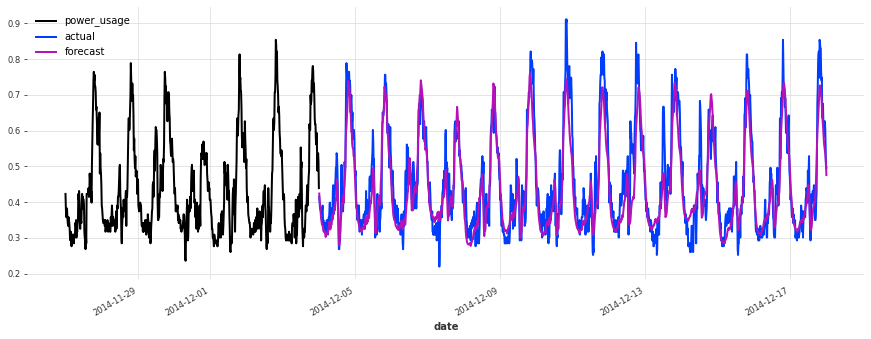

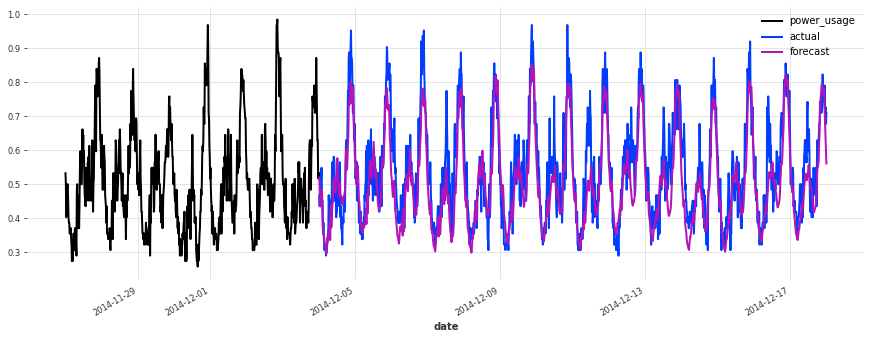

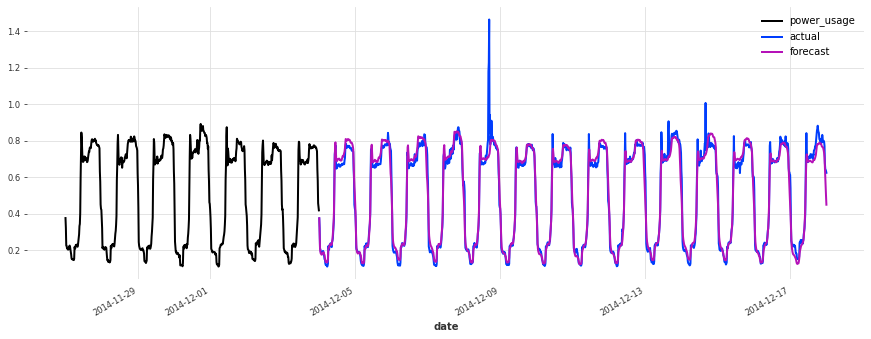

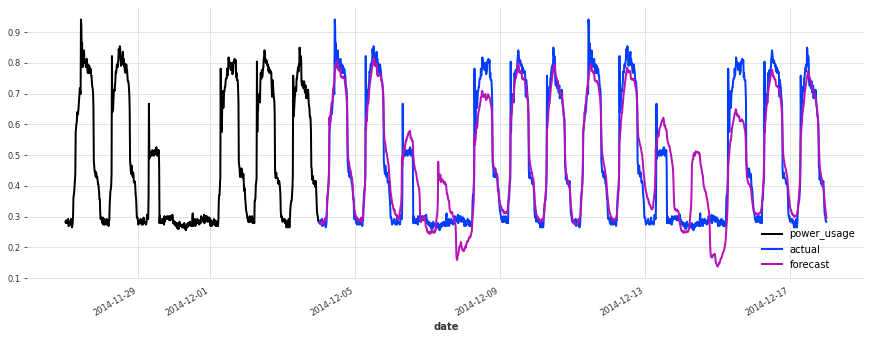

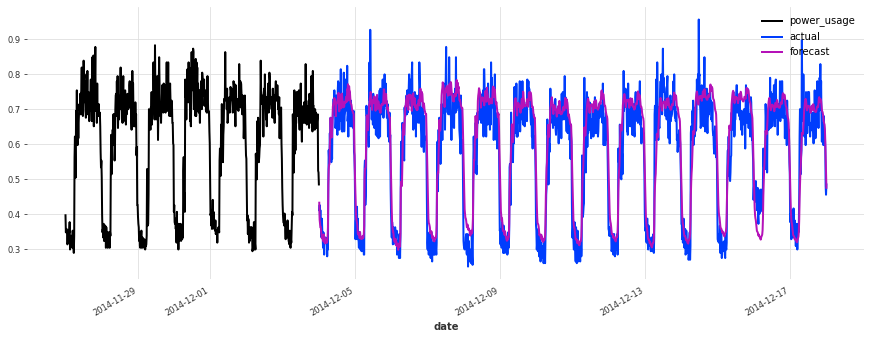

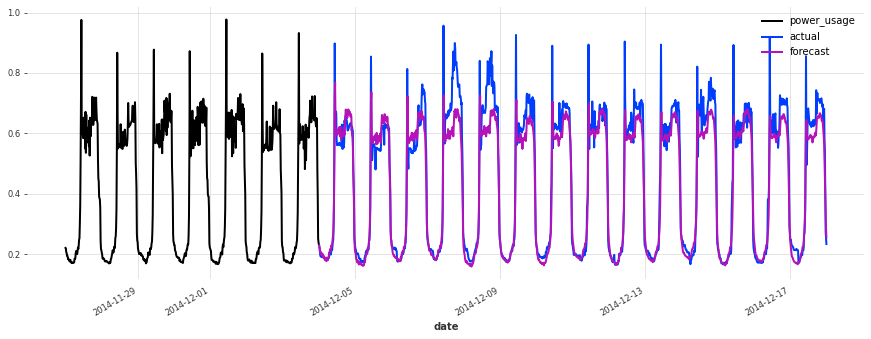

In [30]:
lr_preds = lr_model.predict(series=train, n=val_len)
smape_mean, smape_std = eval_model(lr_preds, 'Linear Regression')
results_df.loc['Linear Regression'] = [smape_mean, smape_std]

# Prophet

In [205]:
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [206]:
prophet_model = Prophet()
prophet_model.fit(train[0])

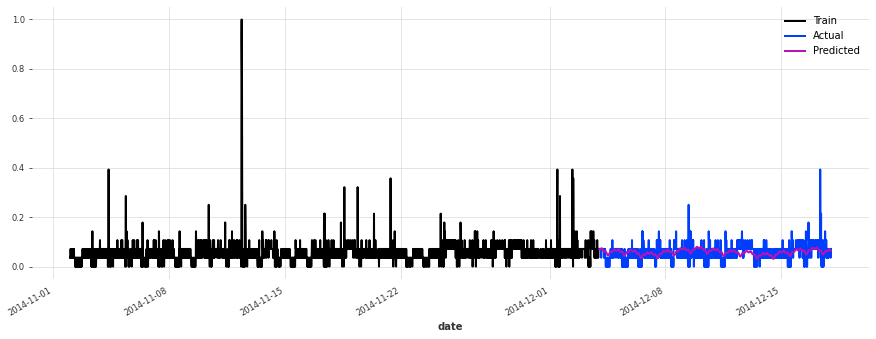

In [197]:
prophet_pred = prophet_model.predict(n=val_len)
plt.figure(figsize=(15, 5))
train[0].plot(label='Train')
val[0].plot(label='Actual')
prophet_pred.plot(label='Predicted')

## Loop

In [208]:
mapes = []
for index in range(len(train)):
  prophet_model = Prophet()
  prophet_model.fit(train[index])
  prophet_pred = prophet_model.predict(n=val_len)
  score = smape(prophet_pred, val[index])
  print(index, score)
  mapes.append(score)
print('Prophet Per Series', np.mean(mapes), np.std(mapes))
results_df.loc['Prophet Per Series'] = [np.mean(mapes), np.std(mapes)]

0 47.51424951178404
1 6.691534498450655
2 12.475486541835908
3 10.61321196236383
4 12.781730453255664
5 11.88069089840808
6 15.50192351795728
7 9.613840808172037
8 14.473481977015787
9 51.01566836284375
10 12.411033200937647
11 13.45089891965065
12 61.645689924109504
13 14.053470811401505
14 11.525282807452442
15 12.990632777874062
16 8.793560502624393
17 13.547482765445713
18 13.081905070355472
19 12.176777794359426
20 10.445346911955781
21 25.472048562430604
22 16.146068036504207
23 19.725523954153502
24 11.649443666086023
25 15.762273012929406
26 15.89786076821938
27 11.920340057066872
28 15.45654066814048
29 10.143476016872356
30 11.939458978553631
31 15.73276572289144
32 12.380831928075226
33 13.862354565790227
34 13.895118324989092
35 66.0551796564025
36 9.490873984716792
37 10.789412801812476
38 16.327912804646665
39 21.75169993471229
40 10.728578413093324
41 11.541583595991229
42 11.070709536543275
43 12.53986562900202
44 47.90883970274004
45 13.941301340124562
46 12.3305189957

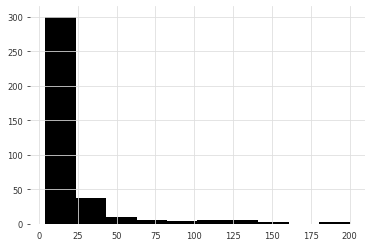

In [210]:
plt.hist(mapes);

# GPU
* Take advantage of a GPU for Deep Learning models
* Configure EarlyStopping callback

In [123]:
def get_trainer_args():
  early_stopping = EarlyStopping('val_loss', min_delta=0.001, patience=3, verbose=True)
  callbacks = [early_stopping]

  if torch.cuda.is_available():
    trainer_kwargs = {
        "accelerator": "gpu",
        "gpus": -1,
        "auto_select_gpus": True,
        "callbacks": callbacks,
    }
    num_workers = 4
  else:
    trainer_kwargs = {"callbacks": callbacks}
    num_workers = 0
  
  return trainer_kwargs

# TCN
* Temporal Convolution Network

![](https://miro.medium.com/max/1169/1*q12eK6HhPYaPUtWxjPta4Q.png)

## Model

In [40]:
pl_trainer_kwargs = get_trainer_args()
tcn_model = TCNModel(input_chunk_length=7 * DURATION, 
                     output_chunk_length=DURATION,
                     n_epochs=3,
                     pl_trainer_kwargs = pl_trainer_kwargs)
tcn_model.fit(train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 452   
----------------------------------------------------
452       Trainable params
0         Non-trainable params
452       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


## Predict

Predicting: 27762it [00:00, ?it/s]

temporal convolution model sMAPE: 20.93 +- 22.14


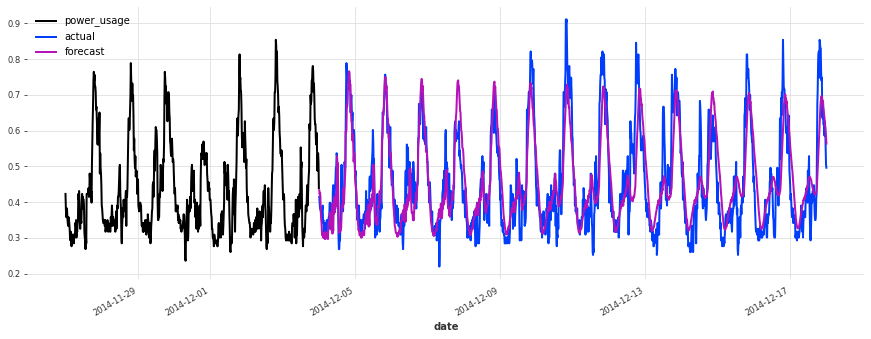

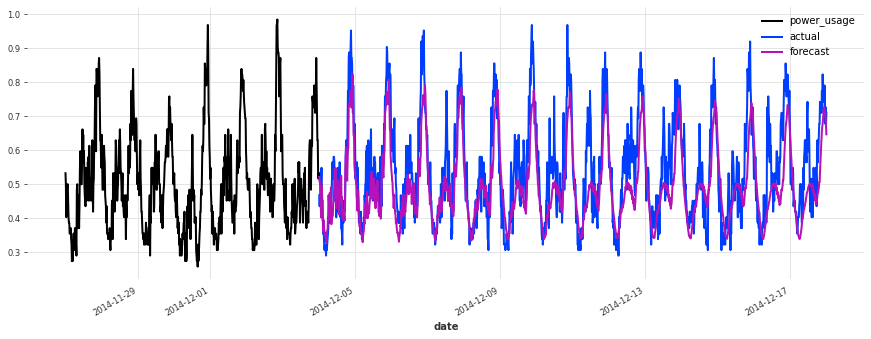

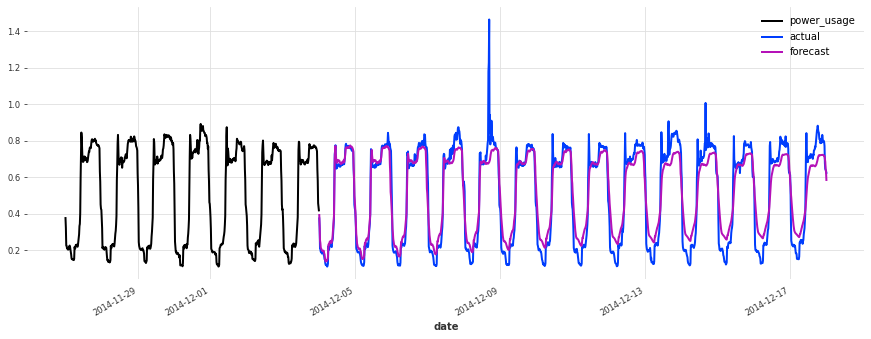

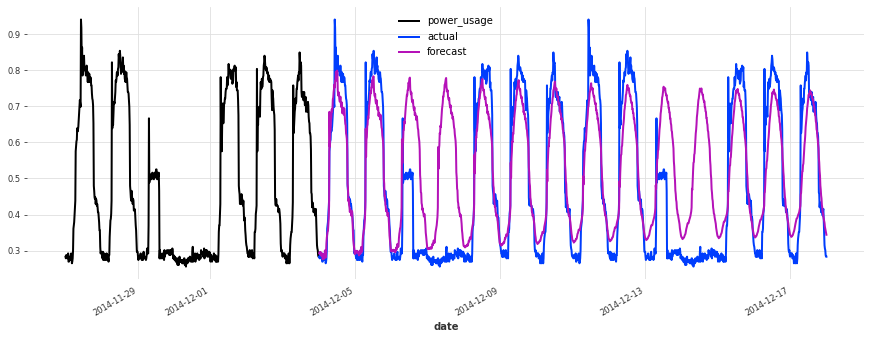

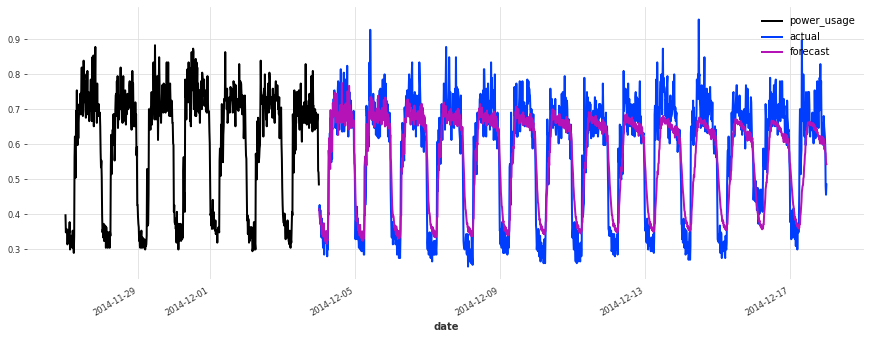

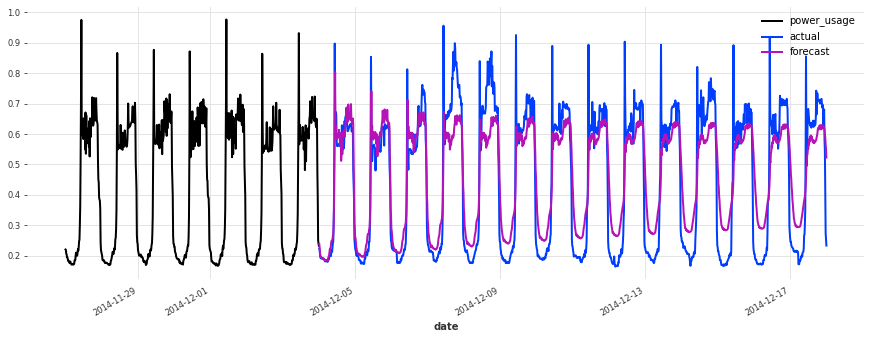

In [41]:
tcn_preds = tcn_model.predict(series=train, n=val_len)
eval_model(tcn_preds, 'Temporal Convolution Model')

# TFT - Single Series

## Model

In [161]:
pl_trainer_kwargs = get_trainer_args()
tft_model = TFTModel(input_chunk_length = 7 * DURATION, 
                     output_chunk_length = DURATION,
                     add_relative_index = True,
                     n_epochs = 5,
                     pl_trainer_kwargs = pl_trainer_kwargs)
tft_model.fit(train[0], val_series=val)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4.115


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 4.111


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 4.104


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## Predict

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 73it [00:00, ?it/s]

TFT - Single sMAPE: 157.35 +- 14.75


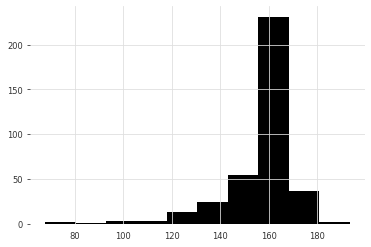

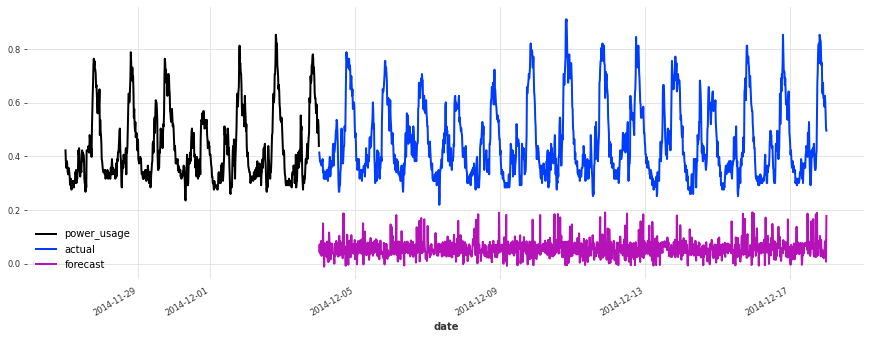

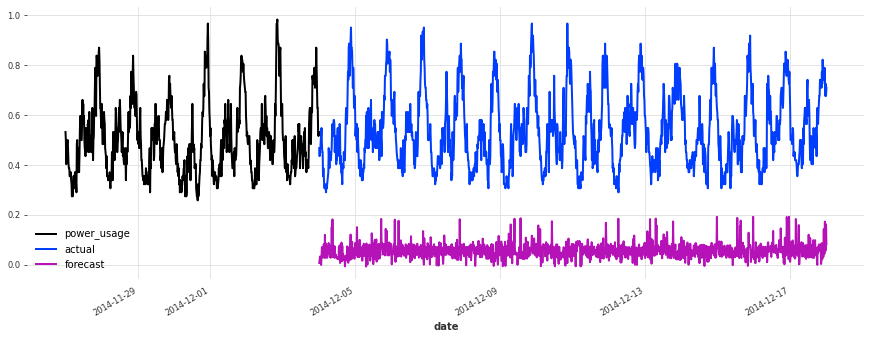

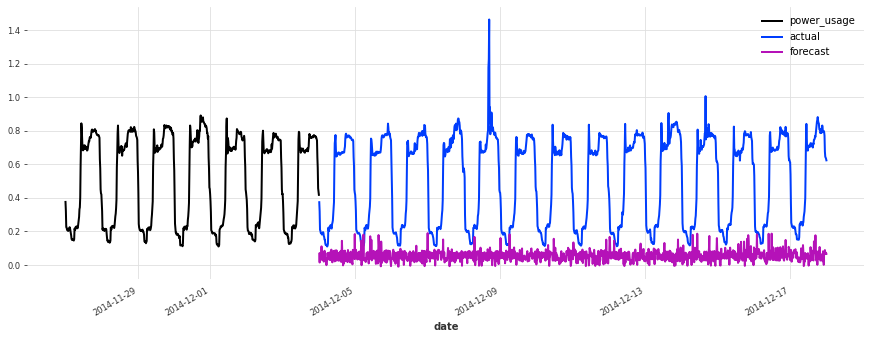

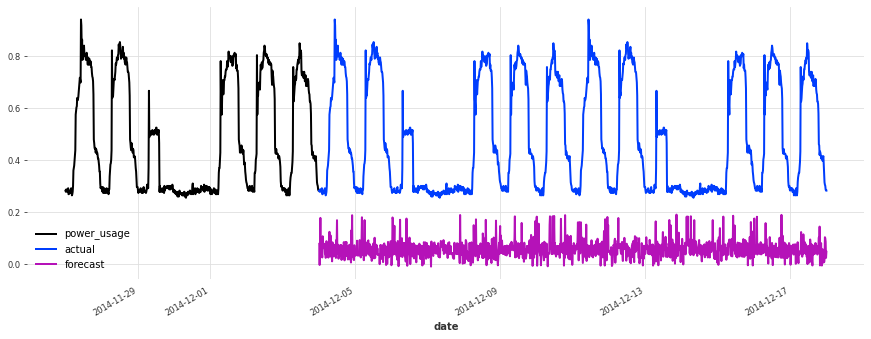

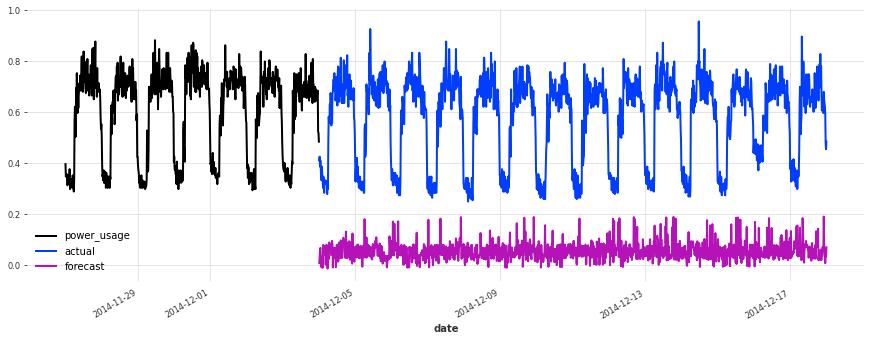

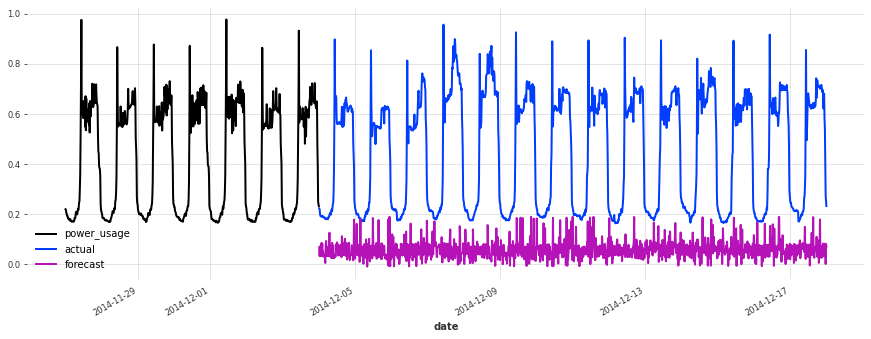

In [162]:
tft_preds = tft_model.predict(series=train, n=val_len)
smape_mean, smape_std = eval_model(tft_preds, 'TFT - Single')
results_df.loc['TFT - Single TimeSeries'] = [smape_mean, smape_std]

## Inspect

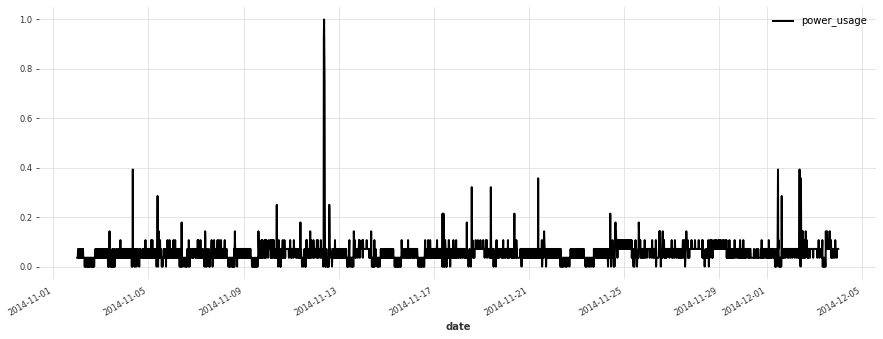

In [168]:
plt.figure(figsize=(15,5))
train[0].plot()

# TFT - Multiple Series

## Model

In [148]:
pl_trainer_kwargs = get_trainer_args()
tft_model = TFTModel(input_chunk_length = 7 * DURATION, 
                     output_chunk_length = DURATION,
                     add_relative_index = True,
                     n_epochs = 1,
                     pl_trainer_kwargs = pl_trainer_kwargs)
tft_model.fit(train, val_series=val)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.358
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


## Predict

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26652it [00:00, ?it/s]

TFT - Multiple sMAPE: 28.25 +- 18.43


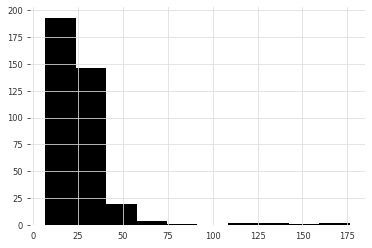

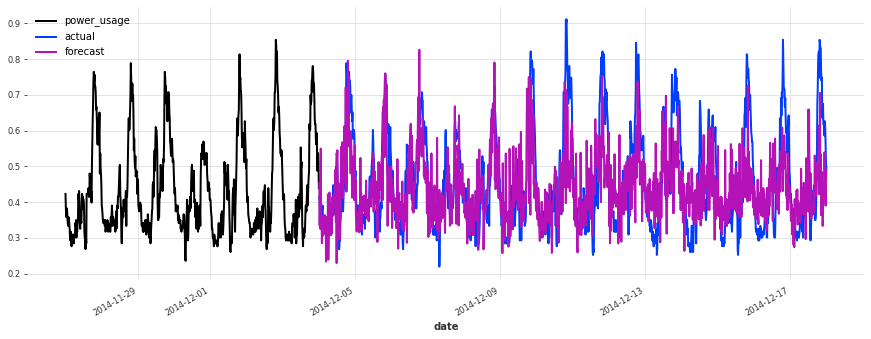

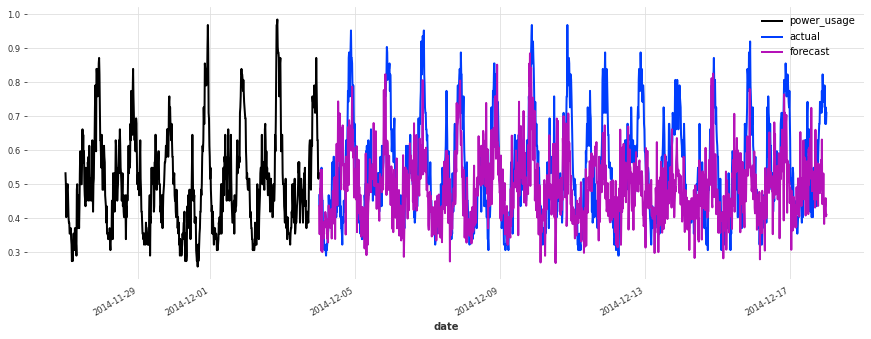

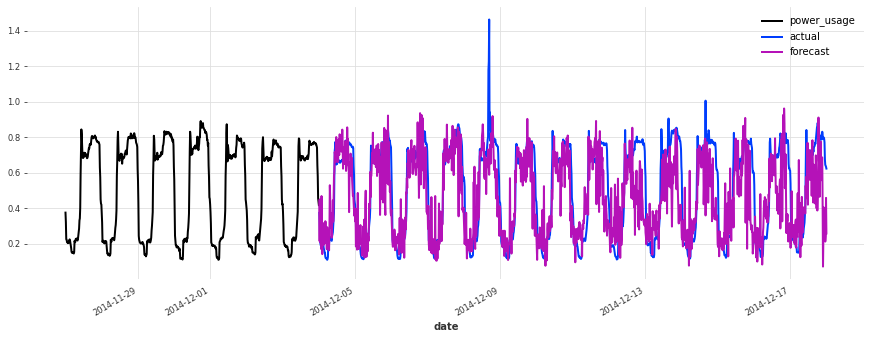

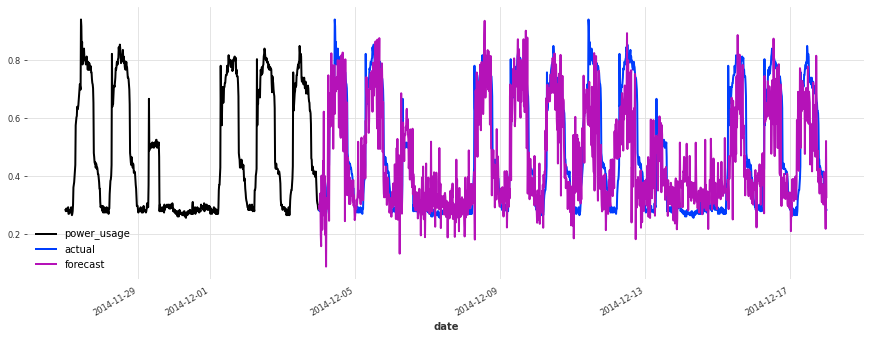

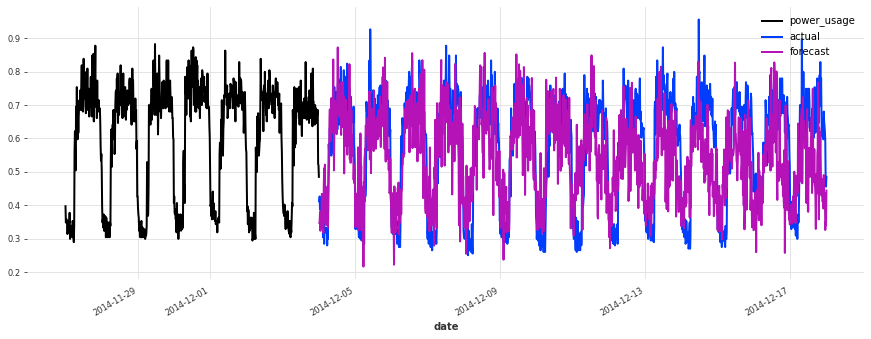

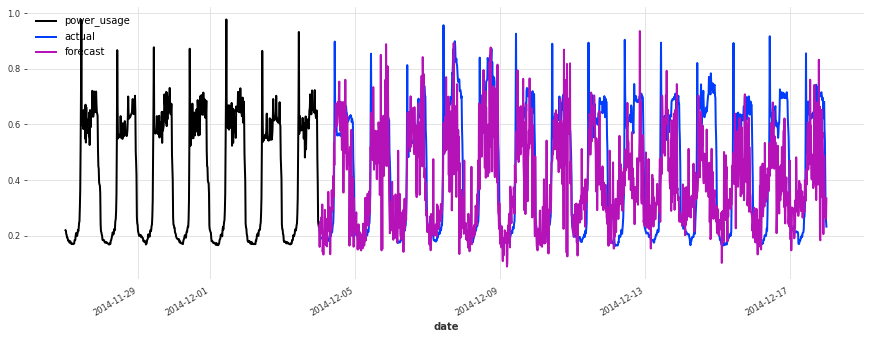

In [149]:
tft_preds = tft_model.predict(series=train, n=val_len)
smape_mean, smape_std = eval_model(tft_preds, 'TFT - Multiple')
results_df.loc['TFT - Multiple TimeSeries'] = [smape_mean, smape_std]

# TFT - Covariates

In [150]:
covariates = []
for item in ds:
  cov = datetime_attribute_timeseries(item, attribute='day', one_hot=False)
  cov = cov.stack(datetime_attribute_timeseries(item, attribute='hour', one_hot=False))
  cov = cov.stack(TimeSeries.from_times_and_values(
        times=item.time_index,
        values=np.arange(len(item)),
        columns=['linear_increase'],
    )
  )
  cov = cov.astype(np.float32)
  covariates.append(cov)

In [154]:
cov_train = [s[: -(2 * val_len)] for s in covariates]
cov_val   = [s[-(2 * val_len) : -val_len] for s in covariates]
cov_test  = [s[-val_len:] for s in covariates]
cov_pred  = [s[: -(2 * val_len) + val_len] for s in covariates]

scaler_covs = Scaler()
covariates_train = scaler_covs.fit_transform(cov_train)
covariates_val   = scaler_covs.transform(cov_val)
covariates_test  = scaler_covs.transform(cov_test)
covariates_pred  = scaler_covs.transform(cov_pred)

## Model

In [152]:
pl_trainer_kwargs = get_trainer_args()
tft_model = TFTModel(input_chunk_length = 7 * DURATION, 
                 output_chunk_length = DURATION,
                 n_epochs=1,
                 pl_trainer_kwargs=pl_trainer_kwargs)
tft_model.fit(train, future_covariates=covariates_train, 
          val_series=val, val_future_covariates=covariates_val, 
          verbose=True)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.334
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


## Predict

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26652it [00:00, ?it/s]

TFT - Covariates sMAPE: 22.07 +- 20.25


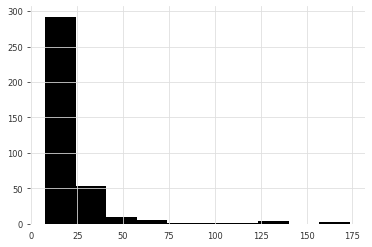

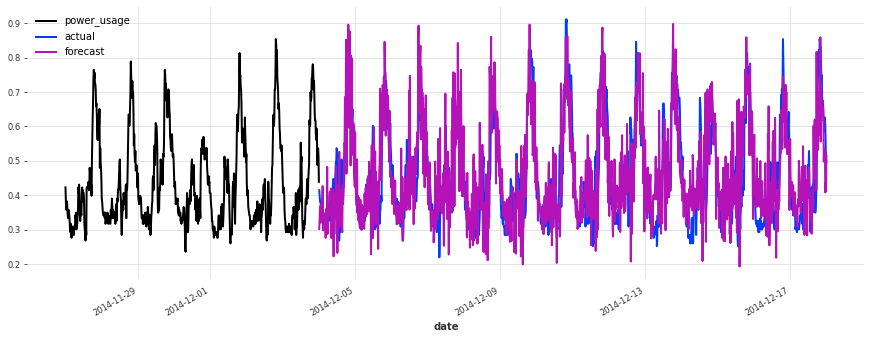

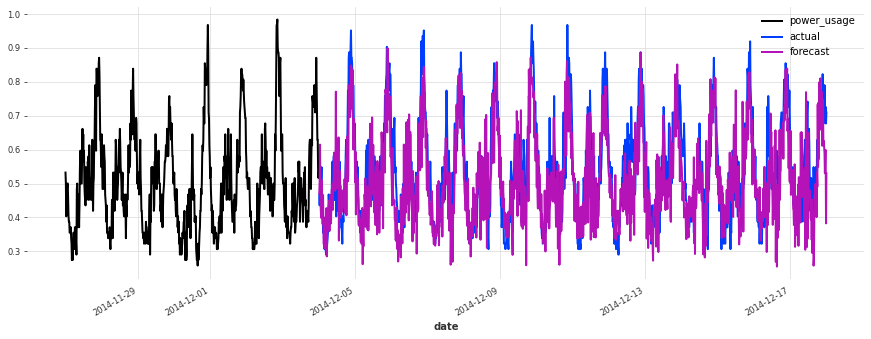

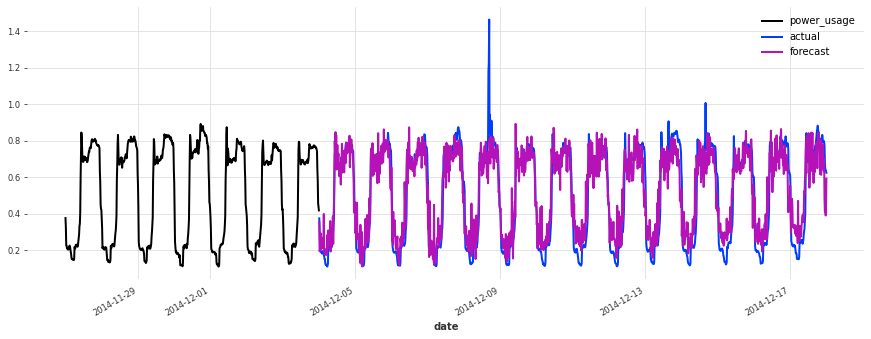

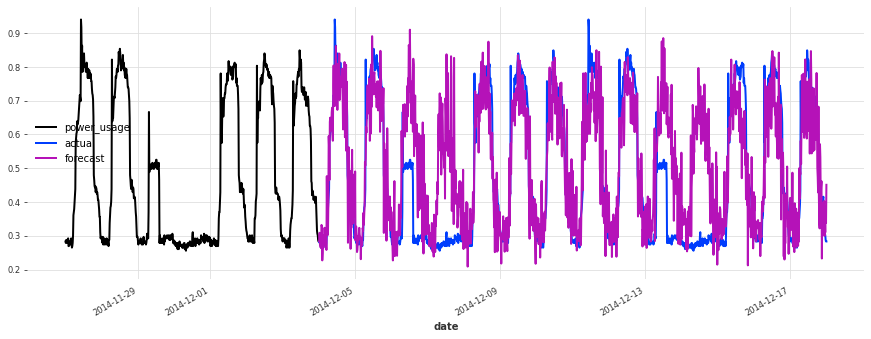

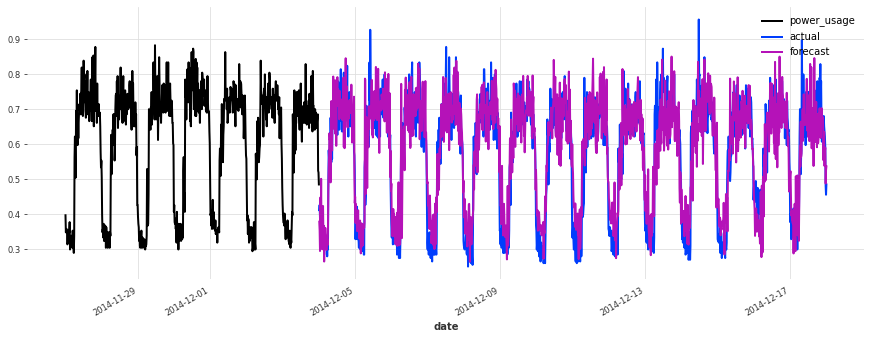

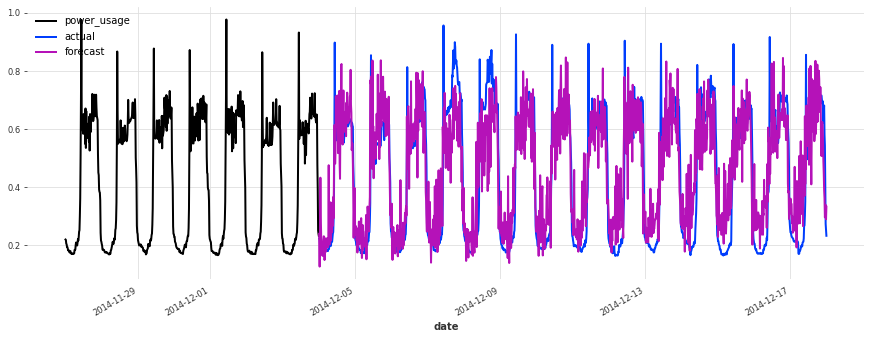

In [155]:
tft_preds = tft_model.predict(series=train, future_covariates=covariates_pred, n=val_len)
smape_mean, smape_std = eval_model(tft_preds, 'TFT - Covariates')
results_df.loc['TFT - Covariates'] = [smape_mean, smape_std]

## Best Predictions

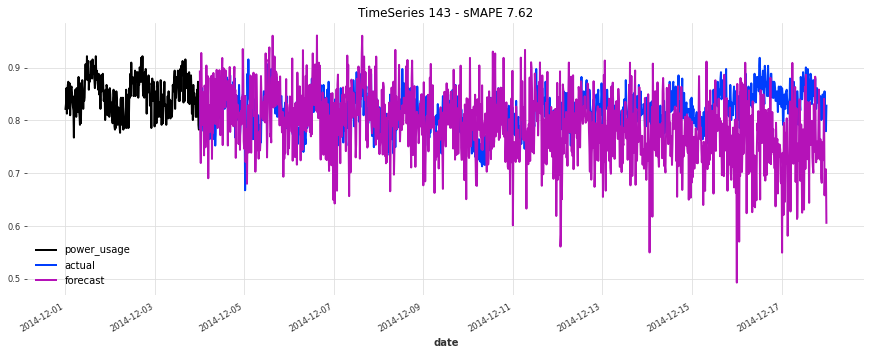

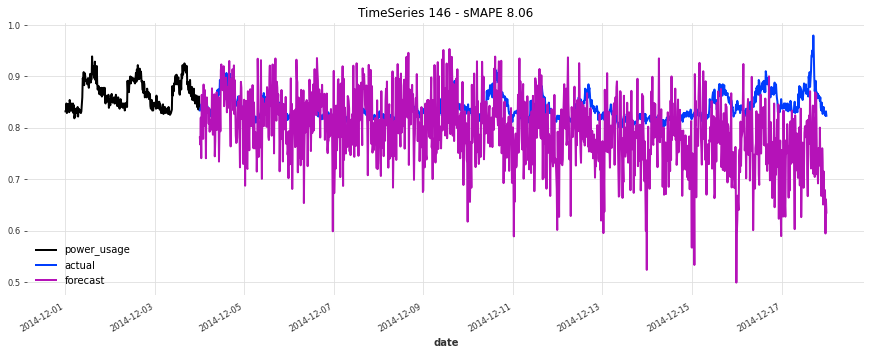

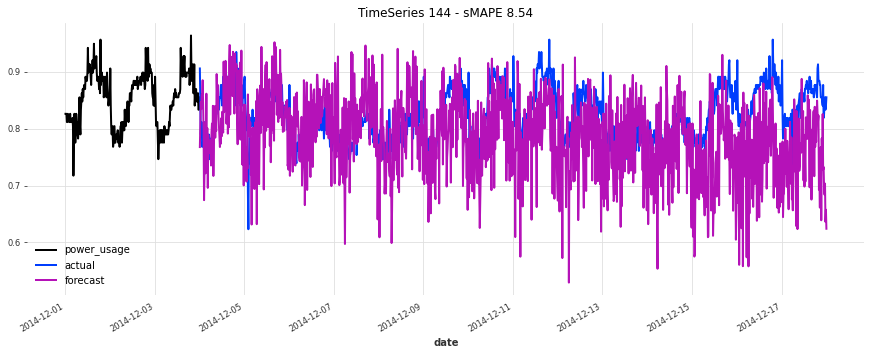

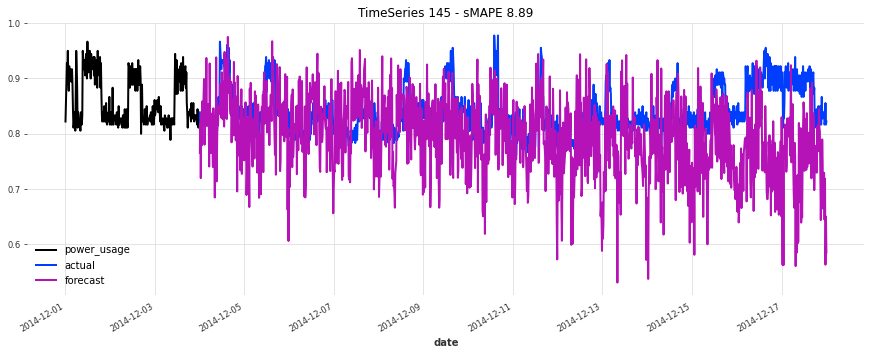

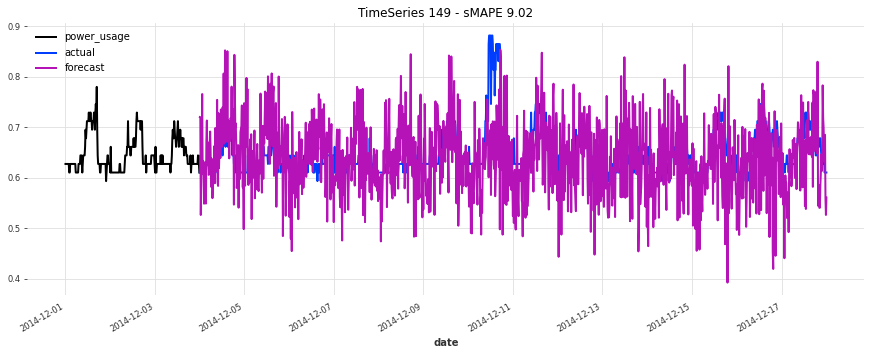

In [156]:
best_predictions(tft_preds)

## Worst Predictions

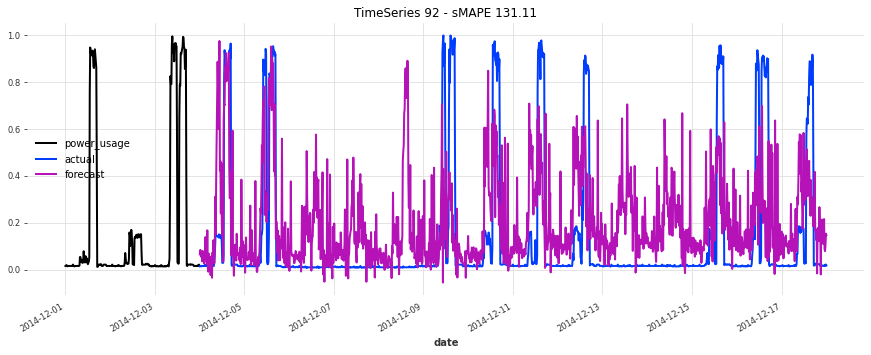

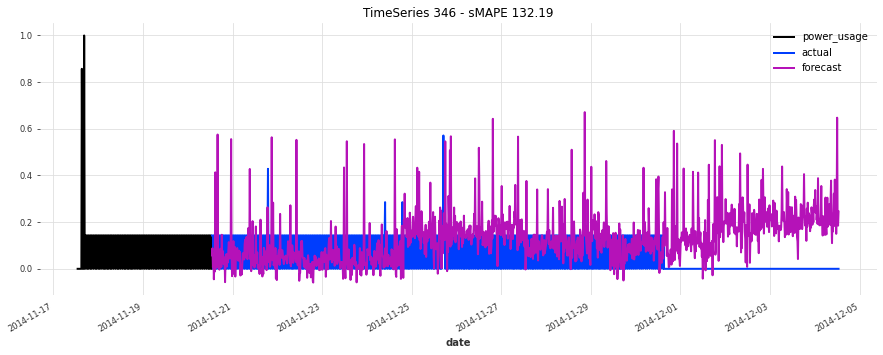

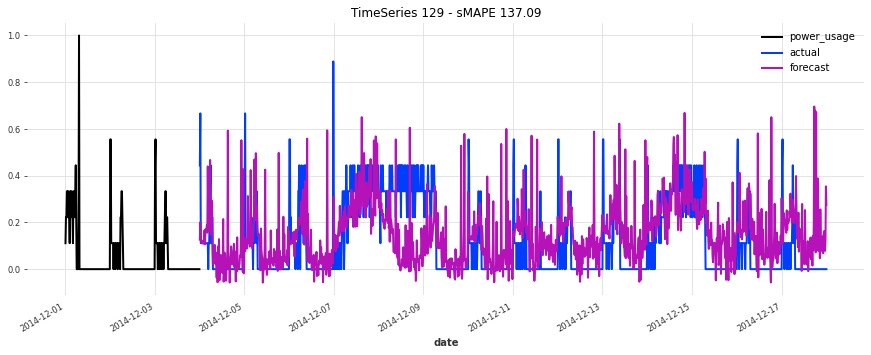

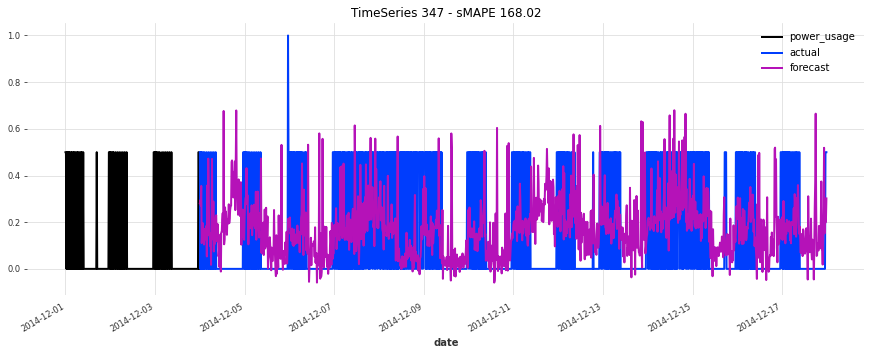

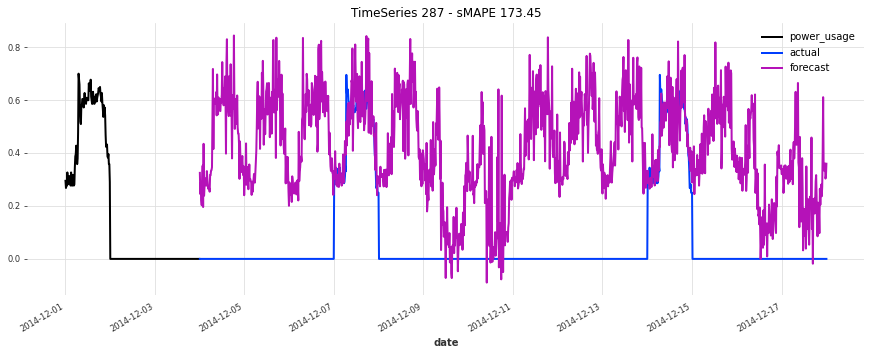

In [157]:
worst_predictions(tft_preds)

# TFT - Additional Epochs

In [212]:
pl_trainer_kwargs = get_trainer_args()
tft_model = TFTModel(input_chunk_length = 7 * DURATION, 
                 output_chunk_length = DURATION,
                 n_epochs=5,
                 pl_trainer_kwargs=pl_trainer_kwargs)
tft_model.fit(train, future_covariates=covariates_train, 
          val_series=val, val_future_covariates=covariates_val, 
          verbose=True)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.331


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.317


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26652it [00:00, ?it/s]

TFT - Covariates Epochs sMAPE: 22.81 +- 23.93


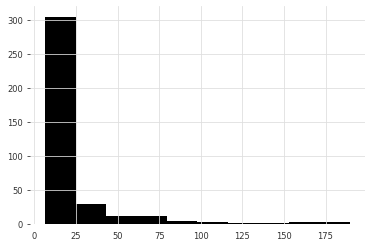

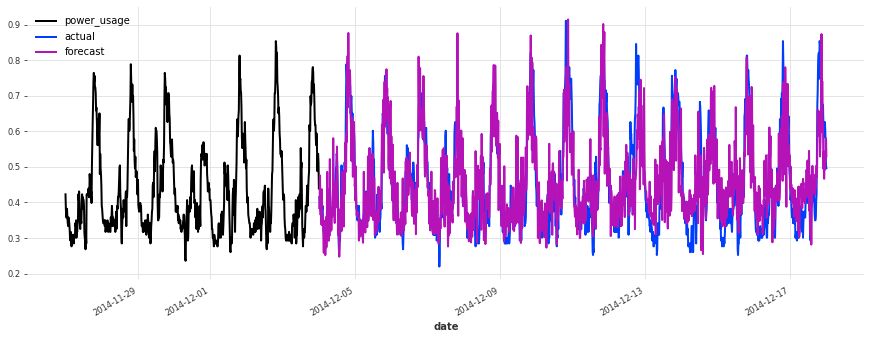

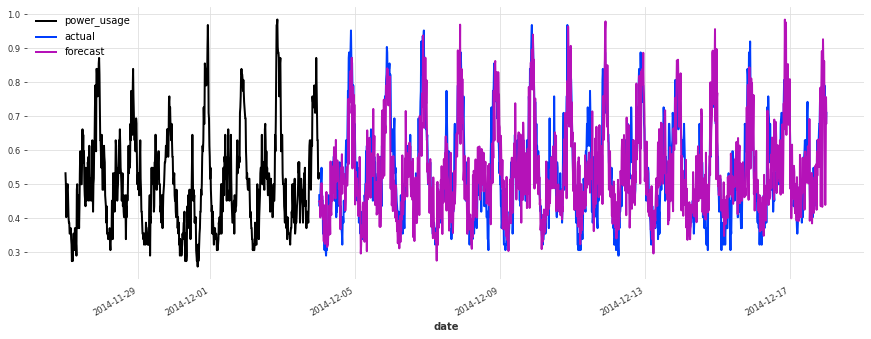

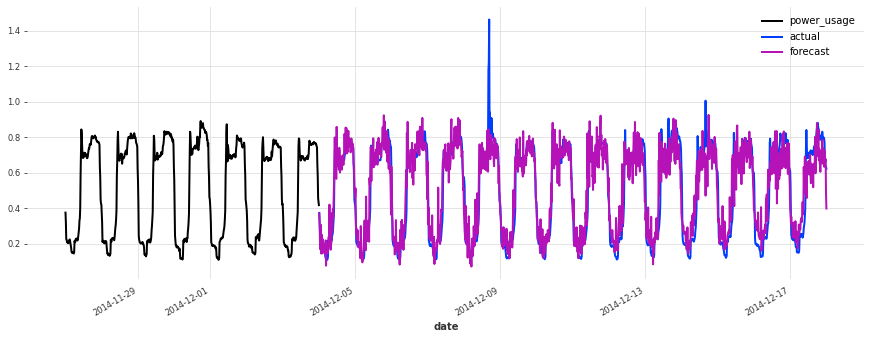

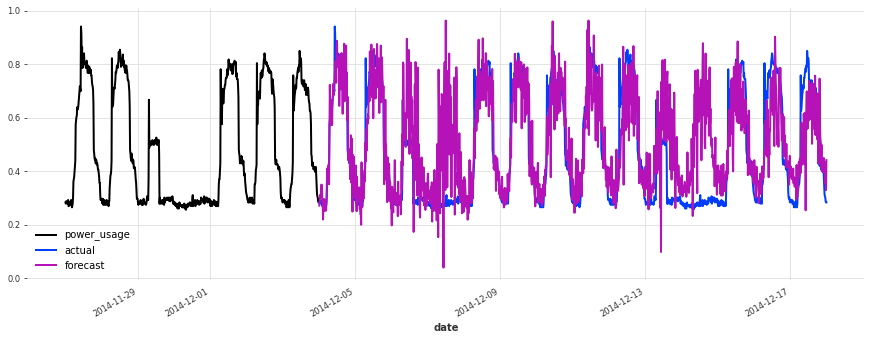

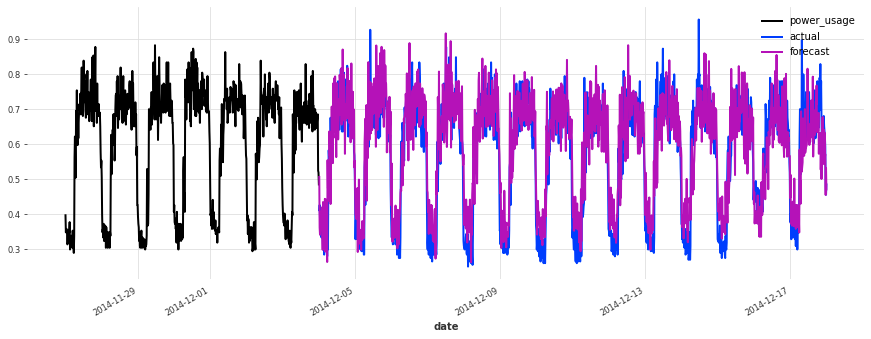

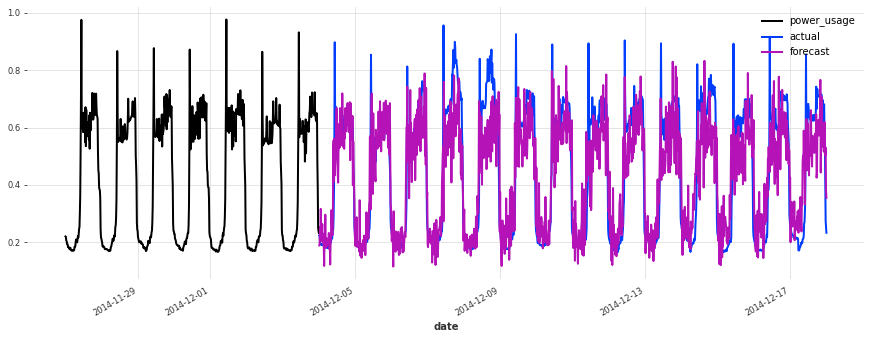

In [213]:
tft_preds = tft_model.predict(series=train, future_covariates=covariates_pred, n=val_len)
smape_mean, smape_std = eval_model(tft_preds, 'TFT - Covariates Epochs')
results_df.loc['TFT - Covariates - Epochs'] = [smape_mean, smape_std]

# Results

In [211]:
holder_df = pd.DataFrame(columns=['sMAPE Mean', 'sMAPE STD'])
holder_df.loc['Linear Regression']         = [15.72, 20.51]
holder_df.loc['TCN']                       = [20.93, 22.14]
holder_df.loc['TFT - Single TimeSeries']   = [154.497997, 11.770314]
holder_df.loc['TFT - Multiple TimeSeries'] = [28.254784, 18.434402]  
holder_df.loc['TFT - Covariates']          = [22.065786, 20.245582]  
holder_df.loc['Prophet per Series']        = [21.251642, 26.8460692] 
holder_df.sort_values('sMAPE Mean')       
holder_df

sMAPE Mean  sMAPE STD
Linear Regression           15.720000  20.510000
TCN                         20.930000  22.140000
TFT - Single TimeSeries    154.497997  11.770314
TFT - Multiple TimeSeries   28.254784  18.434402
TFT - Covariates            22.065786  20.245582
Prophet per Series          21.251642  26.846069

In [158]:
results_df

sMAPE Mean  sMAPE STD
TFT - Single TimeSeries    154.497997  11.770314
TFT - Multiple TimeSeries   28.254784  18.434402
TFT - Covariates            22.065786  20.245582